# spaCy Transformer NER: Fine-Tuning on Informal Video Comments

This notebook demonstrates:
- Loading and preprocessing the dataset.
- Splitting the data into training and evaluation sets.
- Fine-tuning spaCy's transformer-based NER model on informal video comment text.
- Evaluating the model using spaCy's Scorer.
- Saving the best model based on evaluation F-score.

In [1]:
!pip3 install spacy optuna
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.7 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Import Libraries
import spacy
import pandas as pd
import random
import optuna
from spacy.training.example import Example
from spacy.scorer import Scorer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Load and preview the dataset
df = pd.read_csv('../data/4698969/Dataset_updated.csv')
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.head()

,ID,Date,Author,Likes,Replies,Comment,Relevance,Polarity,Feature request,Problem report,Efficiency,Safety,tokens,labels,num_tokens,has_entity,entity_tokens,combined_labels_str
0,UghhPYDEB6B173gCoAEC,2017-04-28T18:12:45Z,Aaron Brown,1679,30,i want what he's smoking,spam,neutral,False,False,False,false,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","['spam', 'neutral', False, False, False, 'false']",6,True,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","False, False, False, false, neutral, spam"
1,Ugh6WAPQinruAHgCoAEC,2017-04-28T18:15:14Z,Felician Cadar,684,22,I love how Musk always makes seemingly wild cl...,spam,positive,False,False,False,false,"['I', 'love', 'how', 'Musk', 'always', 'makes'...","['spam', 'positive', False, False, False, 'fal...",23,True,"['I', 'love', 'how', 'Musk', 'always', 'makes']","False, False, False, false, positive, spam"
2,Ugj9xobHmVeDEHgCoAEC,2017-04-28T18:24:53Z,Kelvin Yang,0,0,No.3,spam,neutral,False,False,False,false,['No.3'],"['spam', 'neutral', False, False, False, 'false']",1,True,['No.3'],"False, False, False, false, neutral, spam"
3,Ugj39PRg5dVn8XgCoAEC,2017-04-28T18:25:31Z,Kelvin Yang,140,4,Could be the start of a historical company,spam,neutral,False,False,False,false,"['Could', 'be', 'the', 'start', 'of', 'a', 'hi...","['spam', 'neutral', False, False, False, 'false']",8,True,"['Could', 'be', 'the', 'start', 'of', 'a']","False, False, False, false, neutral, spam"
4,Ugiu9jMmiWts1HgCoAEC,2017-04-28T18:31:52Z,serendipity42,675,9,Gotta start somewhere before making tunnels on...,spam,neutral,False,False,False,false,"['Got', 'ta', 'start', 'somewhere', 'before', ...","['spam', 'neutral', False, False, False, 'false']",9,True,"['Got', 'ta', 'start', 'somewhere', 'before', ...","False, False, False, false, neutral, spam"


---

## Preprocessing the Dataset

In [4]:
# Basic preprocessing: trim whitespace from text
df['text'] = df['Comment'].apply(lambda x: x.strip())

In [5]:
# Parse the 'entities' column (assumed to be a string representation of a list of tuples)
def parse_entities(entity_str):
    try:
        entities = eval(entity_str)
        return entities
    except Exception as e:
        print(f"Error parsing entities: {entity_str}\nError: {e}")
        return []

In [6]:
def convert_tokens_to_tuples(text, tokens, label="ENTITY"):
    spans = []
    for token in tokens:
        start = text.find(token)
        if start == -1:
            print(f"Token '{token}' not found in text: {text}")
            continue
        end = start + len(token)
        # Check if this span overlaps with any already added span
        overlap = False
        for s, e, _ in spans:
            # If the new span [start, end) overlaps with an existing span [s, e)
            if not (end <= s or start >= e):
                overlap = True
                print(f"Skipping overlapping token '{token}' at ({start}, {end}) in text: {text}")
                break
        if not overlap:
            spans.append((start, end, label))
    return spans

In [7]:
df['parsed_entities'] = df['entity_tokens'].apply(parse_entities)

In [8]:
df.head()

,ID,Date,Author,Likes,Replies,Comment,Relevance,Polarity,Feature request,Problem report,Efficiency,Safety,tokens,labels,num_tokens,has_entity,entity_tokens,combined_labels_str,text,parsed_entities
0,UghhPYDEB6B173gCoAEC,2017-04-28T18:12:45Z,Aaron Brown,1679,30,i want what he's smoking,spam,neutral,False,False,False,false,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","['spam', 'neutral', False, False, False, 'false']",6,True,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","False, False, False, false, neutral, spam",i want what he's smoking,"[i, want, what, he, 's, smoking]"
1,Ugh6WAPQinruAHgCoAEC,2017-04-28T18:15:14Z,Felician Cadar,684,22,I love how Musk always makes seemingly wild cl...,spam,positive,False,False,False,false,"['I', 'love', 'how', 'Musk', 'always', 'makes'...","['spam', 'positive', False, False, False, 'fal...",23,True,"['I', 'love', 'how', 'Musk', 'always', 'makes']","False, False, False, false, positive, spam",I love how Musk always makes seemingly wild cl...,"[I, love, how, Musk, always, makes]"
2,Ugj9xobHmVeDEHgCoAEC,2017-04-28T18:24:53Z,Kelvin Yang,0,0,No.3,spam,neutral,False,False,False,false,['No.3'],"['spam', 'neutral', False, False, False, 'false']",1,True,['No.3'],"False, False, False, false, neutral, spam",No.3,[No.3]
3,Ugj39PRg5dVn8XgCoAEC,2017-04-28T18:25:31Z,Kelvin Yang,140,4,Could be the start of a historical company,spam,neutral,False,False,False,false,"['Could', 'be', 'the', 'start', 'of', 'a', 'hi...","['spam', 'neutral', False, False, False, 'false']",8,True,"['Could', 'be', 'the', 'start', 'of', 'a']","False, False, False, false, neutral, spam",Could be the start of a historical company,"[Could, be, the, start, of, a]"
4,Ugiu9jMmiWts1HgCoAEC,2017-04-28T18:31:52Z,serendipity42,675,9,Gotta start somewhere before making tunnels on...,spam,neutral,False,False,False,false,"['Got', 'ta', 'start', 'somewhere', 'before', ...","['spam', 'neutral', False, False, False, 'false']",9,True,"['Got', 'ta', 'start', 'somewhere', 'before', ...","False, False, False, false, neutral, spam",Gotta start somewhere before making tunnels on...,"[Got, ta, start, somewhere, before, making]"


---

## Train the spaCy model

In [9]:
# Split the dataset into training and evaluation sets (80/20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
train_data = [
    (
        row['text'], 
        {"entities": convert_tokens_to_tuples(row['text'], row['parsed_entities'])}
    )
    for idx, row in train_df.iterrows()
]

eval_data = [
    (
        row['text'], 
        {"entities": convert_tokens_to_tuples(row['text'], row['parsed_entities'])}
    )
    for idx, row in test_df.iterrows()
]

Skipping overlapping token 'is' at (2, 4) in text: This is boring af
Skipping overlapping token 'is' at (21, 23) in text: Anyone else notice this song is in Four Kings Casino on Steam?
Skipping overlapping token 'a' at (11, 12) in text: it should have a tesla supercharger port
Skipping overlapping token 'is' at (5, 7) in text: so this is his 
Tunnel vision?? 
#freekodak
Skipping overlapping token 'his' at (4, 7) in text: so this is his 
Tunnel vision?? 
#freekodak
Skipping overlapping token 'is' at (12, 14) in text: Sorry but this is fucking bullshit
Skipping overlapping token 'of' at (6, 8) in text: Think of the logistics of having carriers ready at all points...
Skipping overlapping token 'is' at (16, 18) in text: Let me guesse this is not coming to Cyprus
Skipping overlapping token 'i' at (4, 5) in text: hmm i think i saw a similar movie that will smith appeared
Skipping overlapping token 'a' at (15, 16) in text: hmm i think i saw a similar movie that will smith appeared
Skipping ov

In [11]:
train_data

[('Tesla claims the future is self driving car, but now shows their future is a car on a flat bed rail car that follows a rail. What a misfire.\n For such a simple and regulated environment as a car only tunnel, it would actually be much easier to make car self drive than on a open road.',
  {'entities': [(0, 5, 'ENTITY'),
    (6, 12, 'ENTITY'),
    (13, 16, 'ENTITY'),
    (17, 23, 'ENTITY'),
    (24, 26, 'ENTITY'),
    (27, 31, 'ENTITY')]}),
 ('Yea but the wait time in line would only be about 8 years',
  {'entities': [(0, 3, 'ENTITY'),
    (4, 7, 'ENTITY'),
    (8, 11, 'ENTITY'),
    (12, 16, 'ENTITY'),
    (17, 21, 'ENTITY'),
    (22, 24, 'ENTITY')]}),
 ('Anybody else reading the comments and establishing the pessimists from the optimists?',
  {'entities': [(0, 7, 'ENTITY'),
    (8, 12, 'ENTITY'),
    (13, 20, 'ENTITY'),
    (21, 24, 'ENTITY'),
    (25, 33, 'ENTITY'),
    (34, 37, 'ENTITY')]}),
 ('Hey elon', {'entities': [(0, 3, 'ENTITY'), (4, 8, 'ENTITY')]}),
 ('loud', {'entities':

In [12]:
eval_data

[('how many tunnels do we need underground? for subway train, hyperloop, boring company,...',
  {'entities': [(0, 3, 'ENTITY'),
    (4, 8, 'ENTITY'),
    (9, 16, 'ENTITY'),
    (17, 19, 'ENTITY'),
    (20, 22, 'ENTITY'),
    (23, 27, 'ENTITY')]}),
 ('Wow, trending video... paging Thunderf00t...',
  {'entities': [(0, 3, 'ENTITY'),
    (3, 4, 'ENTITY'),
    (5, 13, 'ENTITY'),
    (14, 19, 'ENTITY'),
    (19, 22, 'ENTITY'),
    (23, 29, 'ENTITY')]}),
 ("I don't get it.",
  {'entities': [(0, 1, 'ENTITY'),
    (2, 4, 'ENTITY'),
    (4, 7, 'ENTITY'),
    (8, 11, 'ENTITY'),
    (12, 14, 'ENTITY'),
    (14, 15, 'ENTITY')]}),
 ('It sucks it’s only for Tesla',
  {'entities': [(0, 2, 'ENTITY'),
    (3, 8, 'ENTITY'),
    (9, 11, 'ENTITY'),
    (11, 12, 'ENTITY'),
    (14, 18, 'ENTITY')]}),
 ('and i guess the thing called " driving for pleasure" never fits in Elon\'s fucked up brain. guy is lights and clockwork.',
  {'entities': [(0, 3, 'ENTITY'),
    (4, 5, 'ENTITY'),
    (6, 11, 'ENTITY'),
    (1

In [13]:
print(f"Training examples: {len(train_data)}, Evaluation examples: {len(eval_data)}")

Training examples: 3420, Evaluation examples: 855


In [14]:
# Load spaCy's transformer-based pipeline
nlp = spacy.load('en_core_web_sm')

In [15]:
# Add any missing labels to the NER component
ner = nlp.get_pipe("ner")
for text, annotations in train_data:
    for ent in annotations.get("entities", []):
        ner.add_label(ent[2])

In [16]:
# Training loop with evaluation at each iteration
optimizer = nlp.resume_training()
n_iter = 15  # You can adjust the number of iterations
best_fscore = 0.0
best_model = None

In [20]:
# Training loop with evaluation at each iteration
optimizer = nlp.resume_training()
n_iter = 15  # You can adjust the number of iterations
best_fscore = 0.0
best_model = None

for itn in range(n_iter):
    random.shuffle(train_data)
    losses = {}
    for text, annotations in train_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp.update([example], sgd=optimizer, drop=0.2, losses=losses)
    
    # Evaluate on the evaluation set
    scorer = Scorer()
    for text, annotations in eval_data:
        doc = nlp(text)
        example = Example.from_dict(doc, annotations)
        scorer.score([example])
    scores = scorer.score([example])
    fscore = scores.get("ents_f", 0)
    print(f"F-score: {fscore}")
    print(f"Iteration {itn+1}: Losses: {losses}, Evaluation F-score: {fscore}")
    
    # Save the best model (based on F-score)
    if fscore > best_fscore:
        best_fscore = fscore
        best_model_bytes = nlp.to_bytes()
        best_model = spacy.blank("en")
        best_model.from_bytes(best_model_bytes)

F-score: 0.8333333333333334
Iteration 1: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 12037.47545654281}, Evaluation F-score: 0.8333333333333334
F-score: 0.8
Iteration 2: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 10911.776989037635}, Evaluation F-score: 0.8
F-score: 0.6666666666666666
Iteration 3: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 9802.17246822596}, Evaluation F-score: 0.6666666666666666
F-score: 0.7272727272727272
Iteration 4: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 9922.634788136773}, Evaluation F-score: 0.7272727272727272
F-score: 0.8
Iteration 5: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 8550.33703267825}, Evaluation F-score: 0.8
F-score: 0.6666666666666666
Iteration 6: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 9905.753198417853}, Evaluation F-score: 0.6666666666666666
F-score: 0.8
Iteration 7: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1

---

## Evaluate the model

In [21]:
# Evaluation: Show predictions on a few evaluation examples
print("\nSample Evaluation on Test Set:")
for text, annotations in eval_data[:5]:
    doc = best_model(text)
    print("Text:", text)
    print("Predicted Entities:")
    for ent in doc.ents:
        print(f"  - {ent.text} ({ent.label_})")
    print("Ground Truth:", annotations)
    print("------")


Sample Evaluation on Test Set:
Text: how many tunnels do we need underground? for subway train, hyperloop, boring company,...
Predicted Entities:
Ground Truth: {'entities': [(0, 3, 'ENTITY'), (4, 8, 'ENTITY'), (9, 16, 'ENTITY'), (17, 19, 'ENTITY'), (20, 22, 'ENTITY'), (23, 27, 'ENTITY')]}
------
Text: Wow, trending video... paging Thunderf00t...
Predicted Entities:
Ground Truth: {'entities': [(0, 3, 'ENTITY'), (3, 4, 'ENTITY'), (5, 13, 'ENTITY'), (14, 19, 'ENTITY'), (19, 22, 'ENTITY'), (23, 29, 'ENTITY')]}
------
Text: I don't get it.
Predicted Entities:
Ground Truth: {'entities': [(0, 1, 'ENTITY'), (2, 4, 'ENTITY'), (4, 7, 'ENTITY'), (8, 11, 'ENTITY'), (12, 14, 'ENTITY'), (14, 15, 'ENTITY')]}
------
Text: It sucks it’s only for Tesla
Predicted Entities:
Ground Truth: {'entities': [(0, 2, 'ENTITY'), (3, 8, 'ENTITY'), (9, 11, 'ENTITY'), (11, 12, 'ENTITY'), (14, 18, 'ENTITY')]}
------
Text: and i guess the thing called " driving for pleasure" never fits in Elon's fucked up brain. guy is

In [28]:
# --- Define the Objective Function for Hyperparameter Tuning ---
def objective(trial):
    # Suggest hyperparameters: dropout rate and number of training iterations
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    n_iter = trial.suggest_int("n_iter", 10, 20)
    
    # Load a fresh instance of spaCy's transformer model
    nlp = spacy.load("en_core_web_sm")
    
    # Add any missing entity labels to the NER component
    ner = nlp.get_pipe("ner")
    for text, annotations in train_data:
        for ent in annotations.get("entities", []):
            ner.add_label(ent[2])
    
    optimizer = nlp.resume_training()
    
    # Training loop
    for itn in range(n_iter):
        random.shuffle(train_data)
        losses = {}
        for text, annotations in train_data:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], sgd=optimizer, drop=dropout, losses=losses)
    
    # Evaluate on the evaluation set
    scorer = Scorer()
    for text, annotations in eval_data:
        doc = nlp(text)
        example = Example.from_dict(doc, annotations)
        scorer.score([example])
    fscore = scores.get("ents_f", 0)
    
    # Return the F-score as the metric to maximize
    return fscore

In [29]:
# --- Run Optuna Optimization ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

print("Best trial:")
trial = study.best_trial
print(f"  F-score: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-12 16:18:03,384] A new study created in memory with name: no-name-fbb53b19-4aa9-41cd-aaab-944ff8157845
[I 2025-03-12 16:27:16,691] Trial 0 finished with value: 0.7272727272727272 and parameters: {'dropout': 0.28642538561634767, 'n_iter': 16}. Best is trial 0 with value: 0.7272727272727272.
[I 2025-03-12 16:38:57,502] Trial 1 finished with value: 0.7272727272727272 and parameters: {'dropout': 0.16065686846583394, 'n_iter': 20}. Best is trial 0 with value: 0.7272727272727272.
[I 2025-03-12 16:45:56,144] Trial 2 finished with value: 0.7272727272727272 and parameters: {'dropout': 0.3969801581486331, 'n_iter': 12}. Best is trial 0 with value: 0.7272727272727272.
[I 2025-03-12 16:53:30,676] Trial 3 finished with value: 0.7272727272727272 and parameters: {'dropout': 0.35595965537758123, 'n_iter': 13}. Best is trial 0 with value: 0.7272727272727272.
[I 2025-03-12 17:03:55,254] Trial 4 finished with value: 0.7272727272727272 and parameters: {'dropout': 0.1878593574846406, 'n_iter': 1

Best trial:
  F-score: 0.7272727272727272
  Params:
    dropout: 0.28642538561634767
    n_iter: 16


In [30]:
# Optionally, retrain the model with the best hyperparameters
best_dropout = trial.params["dropout"]
best_n_iter = trial.params["n_iter"]

nlp_best = spacy.load("en_core_web_sm")
ner = nlp_best.get_pipe("ner")
for text, annotations in train_data:
    for ent in annotations.get("entities", []):
        ner.add_label(ent[2])
optimizer = nlp_best.resume_training()

for itn in range(best_n_iter):
    random.shuffle(train_data)
    losses = {}
    for text, annotations in train_data:
        doc = nlp_best.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp_best.update([example], sgd=optimizer, drop=best_dropout, losses=losses)
    print(f"Retraining Iteration {itn+1}/{best_n_iter}: Losses: {losses}")

Retraining Iteration 1/16: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 15021.88895238484}
Retraining Iteration 2/16: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 12969.814082427682}
Retraining Iteration 3/16: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 12862.992951066162}
Retraining Iteration 4/16: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 11735.423888716814}
Retraining Iteration 5/16: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 10805.669673235838}
Retraining Iteration 6/16: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 9970.399147725046}
Retraining Iteration 7/16: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 9801.457902156828}
Retraining Iteration 8/16: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 9214.167329003845}
Retraining Iteration 9/16: Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 9941.752180822281}
Retraining Iteration 10/

In [42]:
def evaluate_ner(nlp_model, eval_data):
    examples = []
    for text, annotations in eval_data:
         # Convert the raw text string into a Doc object
         doc = nlp_model(text)
         example = Example.from_dict(doc, annotations)
         examples.append(example)
    return nlp_model.evaluate(examples)

In [48]:
# Evaluate the best model (from hyperparameter tuning or training)
evaluation_scores = evaluate_ner(best_model, eval_data)

# Extracting metrics from the evaluation scores dictionary
precision = evaluation_scores.get("ents_p", 0)
recall = evaluation_scores.get("ents_r", 0)
fscore = evaluation_scores.get("ents_f", 0)

print("### Evaluation Metrics")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F-score:   {fscore:.3f}")

### Evaluation Metrics
Precision: 0.000
Recall:    0.000
F-score:   0.000


/opt/anaconda3/lib/python3.11/site-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text "It sucks it’s only for Tesla" with entities "[(0, 2, 'ENTITY'), (3, 8, 'ENTITY'), (9, 11, 'ENTI...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.

/opt/anaconda3/lib/python3.11/site-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text "This sounds....I'm not going to lie, this sounds i..." with entities "[(0, 4, 'ENTITY'), (5, 11, 'ENTITY'), (11, 15, 'EN...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.

/opt/anaconda3/lib/python3.11/site-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text "Let’s go Elon!" with 

In [49]:
# Optionally, display a few sample predictions vs. ground truth
print("\nSample Predictions on Evaluation Data:")
for text, annotations in eval_data[:5]:
    doc = best_model(text)
    print("Text:", text)
    print("Predicted Entities:", [(ent.text, ent.label_) for ent in doc.ents])
    print("Ground Truth Entities:", annotations["entities"])
    print("------")


Sample Predictions on Evaluation Data:
Text: how many tunnels do we need underground? for subway train, hyperloop, boring company,...
Predicted Entities: []
Ground Truth Entities: [(0, 3, 'ENTITY'), (4, 8, 'ENTITY'), (9, 16, 'ENTITY'), (17, 19, 'ENTITY'), (20, 22, 'ENTITY'), (23, 27, 'ENTITY')]
------
Text: Wow, trending video... paging Thunderf00t...
Predicted Entities: []
Ground Truth Entities: [(0, 3, 'ENTITY'), (3, 4, 'ENTITY'), (5, 13, 'ENTITY'), (14, 19, 'ENTITY'), (19, 22, 'ENTITY'), (23, 29, 'ENTITY')]
------
Text: I don't get it.
Predicted Entities: []
Ground Truth Entities: [(0, 1, 'ENTITY'), (2, 4, 'ENTITY'), (4, 7, 'ENTITY'), (8, 11, 'ENTITY'), (12, 14, 'ENTITY'), (14, 15, 'ENTITY')]
------
Text: It sucks it’s only for Tesla
Predicted Entities: []
Ground Truth Entities: [(0, 2, 'ENTITY'), (3, 8, 'ENTITY'), (9, 11, 'ENTITY'), (11, 12, 'ENTITY'), (14, 18, 'ENTITY')]
------
Text: and i guess the thing called " driving for pleasure" never fits in Elon's fucked up brain. guy is

## Explanation of Results

### Evaluation Metrics
The evaluation metrics for the Named Entity Recognition (NER) model are as follows:

- **Precision**: Precision measures the accuracy of the positive predictions. It is calculated as the number of true positive predictions divided by the total number of positive predictions (true positives + false positives). A higher precision indicates fewer false positives.

- **Recall**: Recall measures the ability of the model to identify all relevant instances. It is calculated as the number of true positive predictions divided by the total number of actual positives (true positives + false negatives). A higher recall indicates fewer false negatives.

- **F-score**: The F-score (or F1-score) is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. A higher F-score indicates a better balance between precision and recall.

### Visualization
The bar chart visualizes the evaluation metrics (Precision, Recall, and F-score) for the NER model. Each bar represents the score for a specific metric, providing a clear comparison of the model's performance across these metrics.

### Hyperparameter Optimization
The optimization history plot shows the changes in the objective value (F-score) over the course of the optimization trials. This helps in understanding how the model's performance improved with different hyperparameter configurations.

The parameter importance plot highlights the significance of each hyperparameter in achieving the best model performance. This helps in identifying which hyperparameters have the most impact on the model's F-score.

### Sample Predictions
The sample predictions section provides a qualitative assessment of the model's performance by comparing the predicted entities with the ground truth entities for a few examples from the evaluation set. This helps in understanding the types of entities the model is able to recognize correctly and where it might be making errors.

In [50]:
# Explanation of Results

# Evaluation Metrics
print("### Evaluation Metrics")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F-score:   {fscore:.3f}")

print("\n### Visualization")
print("The bar chart visualizes the evaluation metrics (Precision, Recall, and F-score) for the NER model. Each bar represents the score for a specific metric, providing a clear comparison of the model's performance across these metrics.")

print("\n### Hyperparameter Optimization")
print("The optimization history plot shows the changes in the objective value (F-score) over the course of the optimization trials. This helps in understanding how the model's performance improved with different hyperparameter configurations.")
print("The parameter importance plot highlights the significance of each hyperparameter in achieving the best model performance. This helps in identifying which hyperparameters have the most impact on the model's F-score.")

print("\n### Sample Predictions")
print("The sample predictions section provides a qualitative assessment of the model's performance by comparing the predicted entities with the ground truth entities for a few examples from the evaluation set. This helps in understanding the types of entities the model is able to recognize correctly and where it might be making errors.")

### Evaluation Metrics
Precision: 0.000
Recall:    0.000
F-score:   0.000

### Visualization
The bar chart visualizes the evaluation metrics (Precision, Recall, and F-score) for the NER model. Each bar represents the score for a specific metric, providing a clear comparison of the model's performance across these metrics.

### Hyperparameter Optimization
The optimization history plot shows the changes in the objective value (F-score) over the course of the optimization trials. This helps in understanding how the model's performance improved with different hyperparameter configurations.
The parameter importance plot highlights the significance of each hyperparameter in achieving the best model performance. This helps in identifying which hyperparameters have the most impact on the model's F-score.

### Sample Predictions
The sample predictions section provides a qualitative assessment of the model's performance by comparing the predicted entities with the ground truth entities for a few

---

## Visualizations

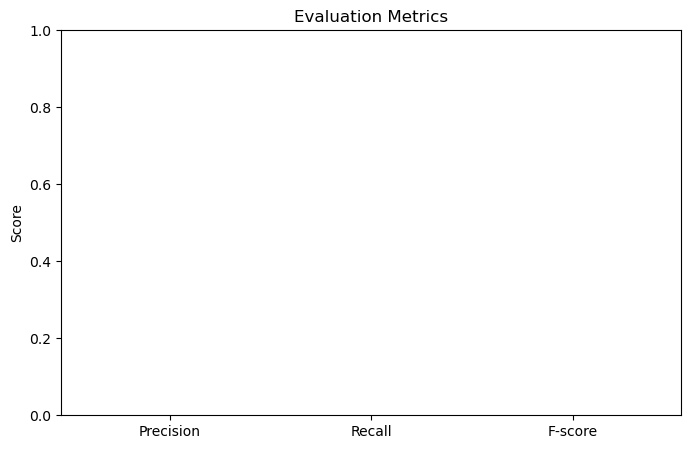

In [51]:
# Extract evaluation metrics
precision = evaluation_scores.get('ents_p', 0)
recall = evaluation_scores.get('ents_r', 0)
fscore = evaluation_scores.get('ents_f', 0)

# Plot the evaluation metrics
metrics = ['Precision', 'Recall', 'F-score']
values = [precision, recall, fscore]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.show()

In [52]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study)
plt.show()

# Plot parameter importance
try:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()
except RuntimeError as e:
    print("Could not compute parameter importances:", e)
    print("This might be due to the limited number of trials or other factors.")

Could not compute parameter importances: Encountered zero total variance in all trees.
This might be due to the limited number of trials or other factors.
